# TDDFT and SAE of a single atom 
Authors:
 - Mousumi Upadhyay Kahaly (ELI-ALPS)
 - Kalyani Chordiya (ELI-ALPS)
 - Gergely Nagy (ELI-ALPS)

Using the lewenstein integral method one cannot account for the multi-electron contribution when it comes to a molecular system. Hence a quantum description which can include the multielectron dynamics is necessary. One such method is using time dependent density functional theory (TDDFT).

In TDDFT method, using Runge-Gross theorem a one-to-one correspondance between the time dependent potentials and densities is established. Hence the TDKS equation is given by:

$$i\frac{\partial}{\partial~t}\phi_i(r,t) = [-\frac{\nabla^2}{2}+V_{ks}[n](r,t)]\phi_i(r,t)$$

$V_{ks}[n](r,t) = V_{ext}(r,t) + V_H[n](r,t)+ V_{XC}[n](r,t)$: KS potential given by one body external potential, non-interacting Hartree potential and XC potential.

$V_H[n](r,t) = \int dr^\prime \frac{n(r^\prime ,t)}{|r-r^\prime|}$: Hartree potential

$\phi_i(r,t)$: KS orbital

$n(r,t) = \sum_i^{N}|\phi_i(r,t)|^2$: Time dependent densiyt of N-interacting systems

Using the time dependent density, one can calculate the time dependent dipole moment:

$$d(t) = \int dr~r n(r,t) = \sum_j \int dr~r|\phi_j(r,t)|^2$$

Acceleration dipole moment can be calculated using the above time dependent dipole moment.

$$a(t) = \frac{d^2}{dt^2}d(t) = -\int dr~n(r,t)\nabla~V_{ks}(r,t)$$

Taking the fourier transform of the induced dipole moment modulus squared we can calculate the harmonic generation dipole power spectrum.

$$P(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}d(t)\end{vmatrix}^2$$

Similarly, taking the fourier transform of the dipole moment acceleration, one can get the harmonic spectrum in the direction of polarization:
$$
H(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}a(t)\end{vmatrix}^2
$$

In this tutorial we will first calculate the time dependent dipole moment using the TDDFT method implemented in the [Octopus code](https://octopus-code.org/wiki/Main_Page). First, we consider an isolated Xenon atom.

## Technical prelude

First, some technical code:

In [1]:
import sys
import os
import shutil
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import constants as const
from ase import io, Atom, Atoms
import pandas as pd

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120   # make figures larger

In [3]:
notebook_path = os.getcwd()
print(notebook_path)

/home/nagyg/Projects/ElissNotebook/Codes/ASE_Octopus_Demo


If your Octopus binaries are in a local folder, add it to `$PATH` here. If they are already there, you can skip the cell below. This works for Linux; on Windows, you have to make sure that Octopus is visible for the system yourself.

In [4]:
Octopus_bin_path = os.environ["HOME"]+"/.local/Octopus/bin"
os.environ['PATH']= ":".join([Octopus_bin_path, os.environ['PATH']])

This folder will be used for the files created while running the simulations.

In [5]:
tmpdir=os.path.abspath(os.path.join(notebook_path, 'calc_atomic_Ar'))
print('Created calculation directory: '+ tmpdir)
os.makedirs(tmpdir,exist_ok=True)
os.chdir(tmpdir)

Created calculation directory: /home/nagyg/Projects/ElissNotebook/Codes/ASE_Octopus_Demo/calc_atomic_Ar


## Useful definitions

In the following, we define some functions that will come handy later in the simulation and postprocessing.

We use SI-derived quantities, but most DFT and TDDFT software - including Octopus - prefers to work in atomic units. The followings will help us with the conversions.

In [6]:
def au_si_conv(value, quantity, target="au"):
    "Convert units from SI to atomic units and back."
    unit = {}
    #    hbar = 1.054571726e-34
    unit["time"] = unit['t'] = 2.4189e-17  # Value of 1 atomic units in second
    unit["q"] = 1.602176565e-19
    unit["m"] = 9.10938291e-31
    unit["length"] = unit['l'] = 5.291772e-11
    unit["omega"] = unit['w'] = 1 / unit["time"]
    unit["energy_ev"] = unit['ev'] = 27.2114
    unit["energy"] = unit["energy_ev"] * unit["q"]
    unit["c"] = unit["length"] / unit["time"]
    unit["d"] = unit["q"] * unit["length"]
    unit["electricfield"] = unit['E'] = 5.142208e11
    unit["intensity"] = unit['I'] = 3.50944758e20

    if target.lower() == "si":
        return value * unit[quantity]
    elif target.lower() in ["au", "a.u."]:
        return value / unit[quantity]
    elif target == 'factor':
        return unit[quantity]
    else:
        raise ValueError(f"target must be 'SI', 'AU' or 'factor' (given: {target})")

# some important conversion factors as constants
C_AU = 137.035999139
C_NM_FS = 299.792458
FS_TO_AU = 41.341374575751
NM_TO_AU = 18.897259886
EV_TO_AU = 0.036749322176
ANGSTR_TO_AU = NM_TO_AU / 10

The harmonic cutoff from an isolated atom can be estimated as
$$
E_{cutoff} = I_p + 3.17*U_p
$$
where $I_p$ is the ionization potential of the atom, and $U_p$ is the ponderomotive energy of the electron in the laser field. In atomic units:
$$
U_p = \frac{I_{laser}}{4\omega^2}
$$

In [7]:
def get_au_cutoff(el_int_au, omega0_au, Ip_ev):
    "Return the cutoff energy (in a.u.) given a laser untensity, frequency, and the Ip in ev."
    Ip = au_si_conv(Ip_ev, "energy_ev")
    Up = el_int_au / (4 * omega0_au ** 2)
    cutoff = Ip + 3.17 * Up
    return cutoff

Octopus input file expects arrays as blocks with items separated by `|`. The following functions help us to write the ASE moleculles in this format:

In [8]:
def array_to_octopus_format(arr):
    if arr.ndim == 1:
        return " | ".join(arr.astype(str).tolist()) 
    elif arr.ndim == 2:
        return "\n".join([" | ".join(arrline.astype(str).tolist()) for arrline in arr])
    else:
        raise ValueError

def coords_to_octopus_format(atom):
    coords = atom.get_scaled_positions() * ANGSTR_TO_AU
    symbols = atom.get_chemical_symbols()
    coordstr = ""
    for sym, coord in zip(symbols, coords):
        coordstr += f'"{sym}" | ' + " | ".join(coord.astype(str).tolist()) + "\n"
    return coordstr


## Simulation setup

Let's choose the atom and the laser parameters for the simulation, as well as the simulation parameters such as the duration and timestep.

#### Parameters and definitions

In [9]:
atom = 'Ar'
Ip_ev = 15.759

In [10]:
pulse_wl = 800                 # Wavelength of the pulse in nm
pulse_I = 1.4e14               # Intensity of the laser pulse in W/cm2 
t_pulse = 3 * pulse_wl/C_NM_FS # duration of the sin2 pulse (half of 0-to-0) in fs
print('t_pulse = ', t_pulse, 'fs')

t_sim = 2*t_pulse+1            # The duration of the simulation in fs.
deltat = 0.006                 # Timestep of the simulation.

cell_size = 10, 10, 10  # x, y, z cell size of the simulation in Angstrom
mesh_spacing = 0.15 # mesh spacing of the Octopus simulation in Angstrom

fft_t_window = t_sim  # FFT window width used to obtain the HHG spectrum from the dipole moment (controls the spectral resolution by zero-paddingg the time-domain signal)
n_fft = int(fft_t_window // deltat)
print("nsteps = ", int(t_sim / deltat))

t_pulse =  8.00553828475565 fs
nsteps =  2835


Some converted quantities:

In [11]:
pulse_omega = 2*np.pi * C_NM_FS / pulse_wl
pulse_eV = 1.2398 / pulse_wl

t_pulse_au = au_si_conv(t_pulse*const.femto, 't', 'au')
pulse_omega_au = au_si_conv(pulse_omega/const.femto, 'w', 'au')
pulse_I_au = au_si_conv(pulse_I * 1e4, 'I', 'au')
E0_au = np.sqrt(pulse_I_au)

For this simulation, we define the laser in the velocity gauge, or in other words, we use the vector potential description. Given a vector potential $A(t)$, the electric field can be obtained as
$$
E(t) = \frac{\mathrm{d}}{c\ \mathrm{d}t} A(t)
$$
Furthermore, we use a $sin^2$ pulse: a laser pulse whose envelope is defined by a cycle of the $sin^2(x)$ function. This is similar to a Gaussian pulse, but provides computational advantages as it has a finite length instead of an exponentially disappearing infinite trail. We define it in such a way that it starts at 0, and ends at $2t_p$:
$$
A(t) = A_0 \sin\left(\frac{\pi t}{2 t_p}\right)^2 
           \left(1-\Theta\left(t-2t_p\right)\right)
           \sin(\omega t)
$$

The vector field will be defined in the Octopus input file by the following string. Octopus will take care of the $cos(\omega t)$ multiplier of the derived $E(t)$, so we exclude it.

In [12]:
A0_au = C_AU * E0_au / pulse_omega_au 
vecfield_envelope_expr = (
    f"{A0_au}*(sin(pi*t/(2*{t_pulse_au})))^2*(1-step(t-2*{t_pulse_au}))"
)

In [13]:
C_AU, E0_au, pulse_omega_au

(137.035999139, 0.06316036599261914, 0.056954559702042315)

#### Setting up things

Let's estimate the cutoff:

In [14]:
e_cutoff = get_au_cutoff(pulse_I_au, pulse_omega_au, Ip_ev)
print(pulse_I_au, pulse_omega_au, Ip_ev)
cutoff_ho = e_cutoff / pulse_omega_au
print(f"Estimated cutoff: {cutoff_ho:.3f} * omega0")

0.003989231832321599 0.056954559702042315 15.759
Estimated cutoff: 27.280 * omega0


Unless you changed the original parameters, we should expect the cutoff at about the 25th harmonic.

In the next step, let's onstruct the atomic coordinates. While using ASE for a single atom is kind of an overkill, it is a handy tool if we would simulate more complex molecules, or would like to automate the process. And the same workflow we use here would work for an arbitrary molecule, which is easy to obtain using ASE. For example, the cell below could also be
```
from ase import molecule
molec = molecule('CH4')
```

and then this notebook would suddenly run the calculations on a $\mathrm{CH}_4$ molecule. We could also download or even create a suitable coordinates file (.xyz, .cif, .pdb...), and load it as 

```
molec = ase.io.read('molec.xyz')
```

Of course, the simulation parameters - such as the cell size, or even the periodicity, for example - would need to be adjusted accordingly, and the TDDFT run would also take much longer.

For now, the "molecule" is trivially simple: a single atom positioned at (0,0,0).

In [15]:
from ase import Atoms
molec = Atoms(atom, positions=[(0., 0., 0.),])

Let's see what did we do:

In [16]:
print(molec.get_chemical_symbols())
print(molec.get_positions())

['Ar']
[[0. 0. 0.]]


In Octopus format, this will look like this:

In [17]:
oct_coords = coords_to_octopus_format(molec)
print(oct_coords)

"Ar" | 0.0 | 0.0 | 0.0



## Ground-state calculation

Now that the setup is done, it's time to execute the Octopus calculation as before. First, we run the ground state calculation. The following cell constructs the input file, and then we write it into the calculation folder. Octopus always looks for the input file at `$PWD/inp`.

In [31]:
gs_input = f"""
FromScratch = yes
CalculationMode = gs            # ground-state calculation
ConvEigenError = true           # 
EigensolverTolerance = 1e-9
# PeriodicDimensions = 0

Spacing = {mesh_spacing}*angstrom
ExtraStates = 0

BoxShape = parallelepiped
%Lsize 
{cell_size[0]}*angstrom | {cell_size[1]}*angstrom | {cell_size[2]}*angstrom
%

% Coordinates
{oct_coords}%

PseudopotentialSet = hgh_lda

# This would help with parallel execution
# ParDomains = auto
# ParStates  = auto

# SymmetrizeDensity = no

%Output
 dos
 geometry | xcrysden
%

"""

In [32]:
with open("inp", "w") as f:
    print(gs_input, file=f)

To get more info about the input parameters, you can use the `oct-help` command-line utility:

In [33]:
parameter_to_lookup = "Lsize"
os.system(f"oct-help -p " + parameter_to_lookup)

Variable: Lsize
Type:     block
Section:  Mesh::Simulation Box


0

Description:
    If BoxShape is parallelepiped, hypercube,
    box_image, or user_defined, this is a block of the form:
    
    %Lsize
      sizex | sizey | sizez | ...
    %
    
    where the size* are half the lengths of the box in each direction.
    
    The  number of columns must match the dimensionality of the calculation. If
    you want a cube you can also set Lsize as a single variable.


Time to run the Octopus calculation. The ground state should be finished in a few seconds, since we only have a single atom.

In [36]:
os.system("octopus | tee octopus.log")

Let's check the convergence by plotting the energy differences between the consecutive steps on a logarithmic scale. If all goes well, we should see a roughly exponential decrease.

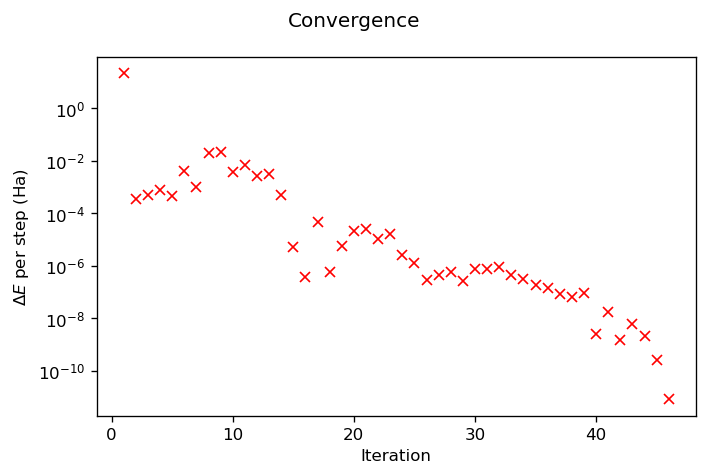

In [40]:
iter, energy, energy_diff, abs_dens, rel_dens, abs_ev, rel_ev = np.genfromtxt(os.path.join("static", "convergence"), skip_header=1, unpack=True)
plt.semilogy(iter, energy_diff, 'rx')
plt.xlabel('Iteration'); plt.ylabel(r'$\Delta E$ per step (Ha)'); plt.suptitle("Convergence"); plt.tight_layout()

Let's also take a glance the DOS. We should see two peaks corresponding to two energy levels.

Efermi =  -0.381689


Text(0, 0.5, 'DOS')

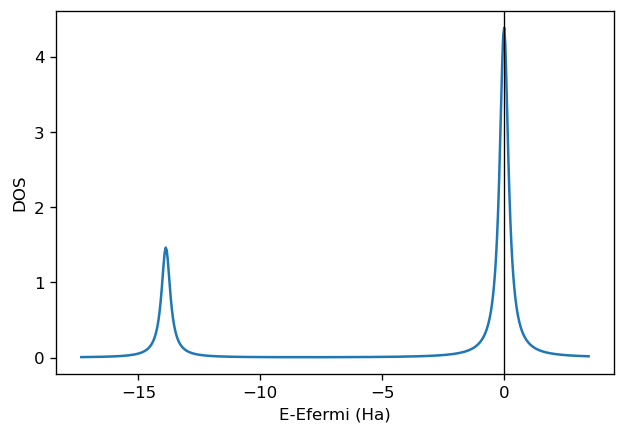

In [41]:
(efermi, _), _ = np.genfromtxt("static/total-dos-efermi.dat", skip_header=1, unpack=True)
doseng, dos = np.genfromtxt("static/total-dos.dat", skip_header=1, unpack=True)

print("Efermi = ", efermi)
plt.plot((doseng-efermi) / EV_TO_AU, dos * EV_TO_AU)
plt.axvline(0, color='k', linewidth=0.8)
plt.xlabel("E-Efermi (Ha)")
plt.ylabel("DOS")

Everything seems fine, so it's time to create the input file for the propagation.

In [45]:
td_input = f'''
FromScratch = yes

CalculationMode = td

Spacing = {mesh_spacing}*angstrom
ExtraStates = 0
PeriodicDimensions = 0

BoxShape = parallelepiped
%Lsize 
{cell_size[0]}*angstrom | {cell_size[1]}*angstrom | {cell_size[2]}*angstrom
%

% Coordinates
{oct_coords}%

PseudopotentialSet = hgh_lda


#----------------------TD-Part------------------------------------#

TDPropagator = aetrs
TDExponentialMethod = lanczos
TDExpOrder = 16

TDPropagationtime = {t_sim}/0.024 # in a.u.
TDTimeStep = {deltat}/0.024   # in a.u.

%TDFunctions
    "envelope" | tdf_from_expr | "{vecfield_envelope_expr}"
     "CEP" | tdf_cw | 0
%

omega_au = {pulse_omega_au} 
%TDExternalFields
 vector_potential | 1 | 0 | 0 | omega_au | "envelope" | "CEP"
%

# %OutputMatrixElements
# dipole
# %

%TDOutput
  laser
  dipole_acceleration
  # total_current
  # energy
  # pol_density
%
'''

In [46]:
with open("inp", "w") as f:
    print(td_input, file=f)

Run the time-dependent calculation. On an average system and a serial Octopus execution, this takes about an hour, so for the lesson, we already executed this and obtained the neccessary output files. 

If you want, feel free to test around and run this before/after the lesson. If you installed/complied Octopus with MPI support, you can take advantage of it and use `os.system("mpirun octopus | tee octopus.log")` instead to enjoy a massive speedup.

In [ ]:
RUN_TDDFT = False
if RUN_TDDFT:
    print("Number of simulation steps: ", int(t_sim / deltat))
    os.system("octopus | tee octopus.log")

That done, let's load the vector field $A(t)$ Octopus was using, and convert it to electric field $E(t) = \frac{\mathrm{d}A(t)}{c\ \mathrm{d}t}$.  As our laser is polarized in the x direction, we only have to load the x component. In the following, we also have to keep in mind that Octopus (with the current input) outputs everything in atomic units.

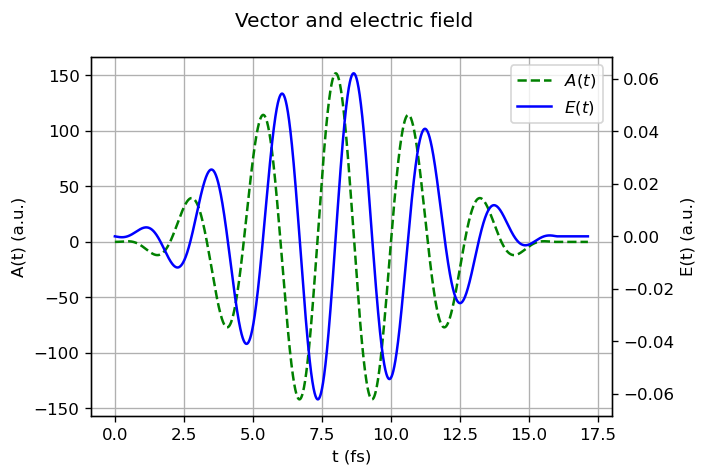

In [77]:
t_au, vecpot_au = np.genfromtxt(os.path.join("td.general", 'laser'), usecols=(1,2), unpack=True)
E_au = -np.gradient(vecpot_au, t_au) / C_AU

fig, axa = plt.subplots()
axe = axa.twinx()
p1, = axa.plot(t_au/FS_TO_AU, vecpot_au, 'g--', label=r'$A(t)$')
p2, = axe.plot(t_au/FS_TO_AU, E_au, 'b-', label=r'$E(t)$')

# add labels and title
axa.set_xlabel('t (fs)'); axa.set_ylabel('A(t) (a.u.)'); axe.set_ylabel('E(t) (a.u.)'); fig.suptitle("Vector and electric field")
axa.legend(handles=[p1,p2])
axa.grid()
plt.tight_layout()

Time to calculate the HHG spectrum. As outlined in the beginning, we can calculate this as
$$
H(\omega) = \frac{1}{t_f^2}\begin{vmatrix}\int_0^{t_f}dt~e^{-i\omega~t}a(t)\end{vmatrix}^2
$$
Utilizing the Fourier identity $\mathscr{F}\left\{\frac{\mathrm{d}f(t)}{\mathrm{d}t}\right\} = \mathrm{i}\omega\mathscr{F}\left\{f(t)\right\}$, we can write the above as
$$
H(\omega) = \begin{vmatrix}-\omega^2 \mathscr{F}\left\{d(t)\right\}\end{vmatrix}^2
$$

The code below calculates the HHG spectrum from the dipole moment calculated by Octopus this way.

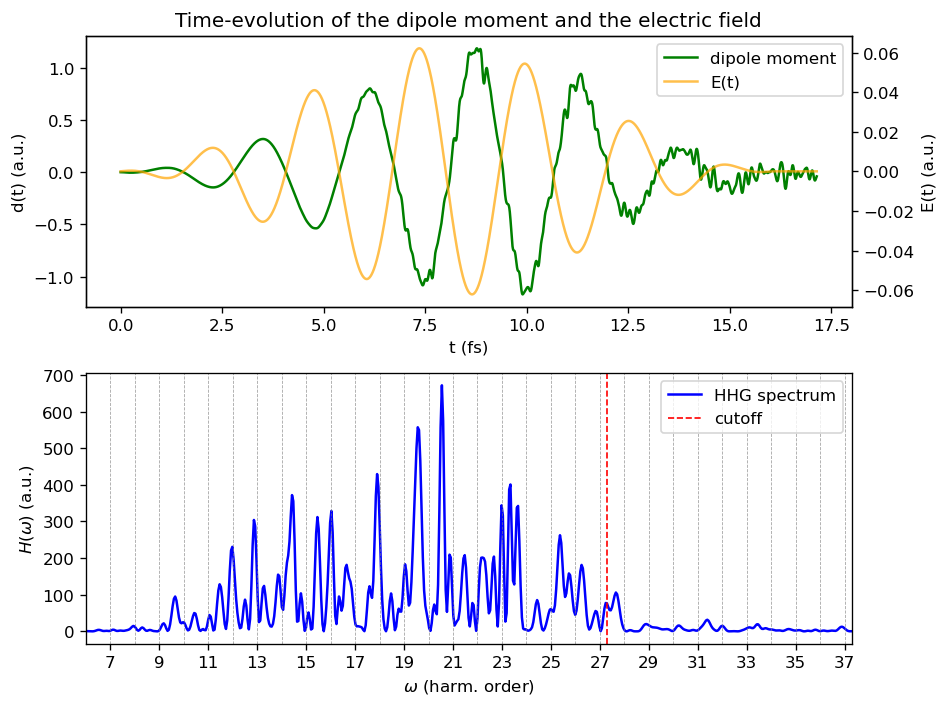

In [76]:
### Read data and calculate FFT ###
fft_t_window = 3*t_sim  # FFT window width used to obtain the HHG spectrum from the dipole moment (controls the spectral resolution by zero-paddingg the time-domain signal)
n_fft = int(fft_t_window // deltat)

fpath = os.path.join("td.general", "multipoles")
t_au, dpx, dpy,dpz = np.genfromtxt(fpath, usecols=(1,3,4,5), unpack=True)
dipole = dpx # depending on the laser polarization, ours is x-linear

# do the fft
dt = t_au[1] - t_au[0]
oms = 2*np.pi*fftshift(fftfreq(n_fft,d = np.abs(dt))) # FFT angular frequency
# oms = 2*np.pi*fftshift(fftfreq(t_au.size,d = np.abs(dt))) # FFT angular frequency
ft_d = - fftshift(fft(dipole, n=n_fft)) * oms**2
hhg = np.abs(ft_d)**2

# the harmonic orders
ho = oms / pulse_omega_au
t_si = t_au / FS_TO_AU

# plot the laser field and the dipole moment VS time
fig, (axt, axw) = plt.subplots(2,1, figsize=(8,6))
axl = axt.twinx()
p1, = axt.plot(t_si, dipole, 'green', label='dipole moment')
p2, = axl.plot(t_si, E_au, 'orange', alpha=0.7, label='E(t)')
axt.set_xlabel('t (fs)')
axt.set_ylabel('d(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and the electric field")
axl.legend(handles=[p1, p2])

# plot the HHG spectra
p3, = axw.plot(ho, hhg, 'blue', label='HHG spectrum')
axw.set_xticks([1+2*i for i in range(50)])
axw.set_xlim(6, cutoff_ho+10)
# axw.set_ylim(0*np.amax(hhg)*1e-4, np.amax(hhg)*1e-3)
# axw.set_ylim(0, 10)
for i in range(100):
    axw.axvline(i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
p4 = axw.axvline(cutoff_ho, linewidth=1.0, linestyle='--', color='red', label='cutoff')
axw.set_xlabel(r'$\omega$ (harm. order)')
axw.set_ylabel(r'$H(\omega)$ (a.u.)')
axw.legend(loc='upper right', handles=[p3, p4])

plt.tight_layout()

We an compare this to an experimental result, for example to this one:

![Experimental HHG](images/hhg_exp_ref.png "Experimental HHG")

*Riedel et. al. (2001). Tunable pulsed vacuum ultraviolet light source for surface science and materials spectroscopy based on high order harmonic generation. Review of Scientific Instruments. 72. 1977-1983. 10.1063/1.1351835.*

The above was obtained from an argon jet using a tunable Ti:sapphire laser source with an $1.4 \cdot 10^{14}\frac{\mathrm{W}}{\mathrm{cm}^2}$ intensity and a $t_p=120\mathrm{fs}$ pulse duration.

### Lewenstein model using HHGMax

Let's compare our result with the Lewenstein model, using the same code as in the previous notebook. After some appropiate unit conversions, we feed the code the electric field we got from the Octopus run, and then calculate the HHG spectrum from the dipole moment the same way as before.

In [129]:
from hhgmax import pylewenstein as pylew

wl_si = pulse_wl*const.nano
fwhm_si = t_pulse*const.femto
Ip_si = Ip_ev * pylew.e
pulse_I_si = pulse_I * 1e4
t_si = (au_si_conv(t_au, 't', 'si'))
E_si = au_si_conv(E_au, 'E', 'si')

d_lew = pylew.lewenstein(t_si, E_si, Ip_si, wl_si)

ft_d_lew = - fftshift(fft(d_lew, n=n_fft)) # * oms**2
hhg_lew = np.abs(ft_d_lew)**2
hhg_lew /= np.amax(hhg_lew)

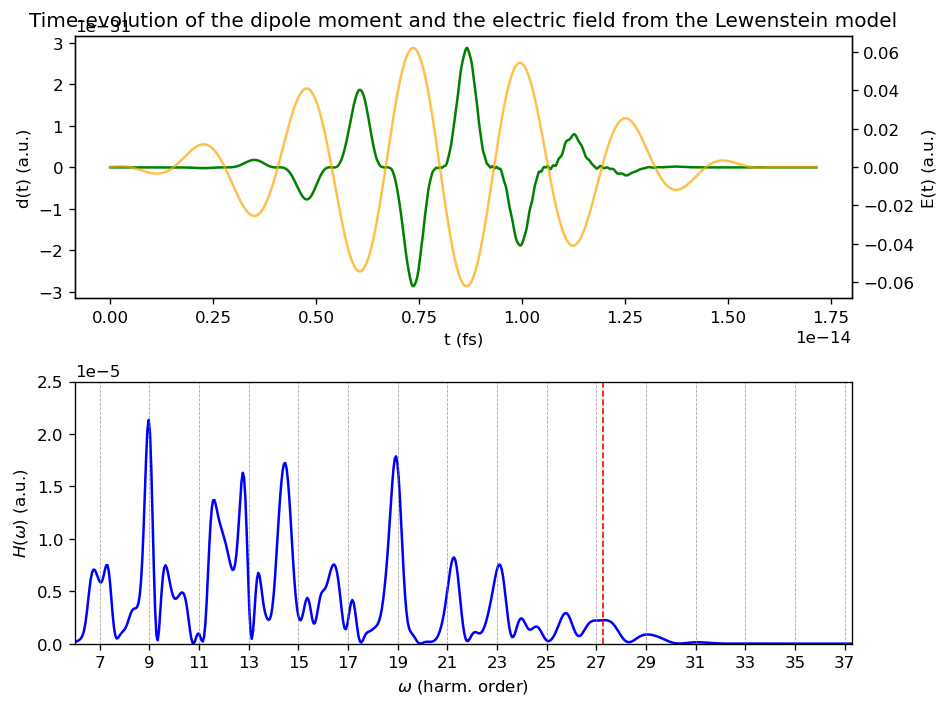

In [147]:
# plot the laser field and the dipole moment VS time
fig, (axt, axw) = plt.subplots(2,1, figsize=(8,6))
axl = axt.twinx()
p1lw, = axt.plot(t_si, d_lew, 'green', label='Lew. dipole moment')
# p1td, = axt.plot(t_si, dipole, 'blue', linestyle='--', linewidth=1.0, label='TDDFT dipole moment')
p2, = axl.plot(t_si, E_au, 'orange', alpha=0.7, label='E(t)')
axt.set_xlabel('t (fs)')
axt.set_ylabel('d(t) (a.u.)')
axl.set_ylabel('E(t) (a.u.)')
axt.set_title("Time-evolution of the dipole moment and the electric field from the Lewenstein model")
# axl.legend(handles=[p1lw, p1td, p2])

# plot the HHG spectra
p3lw, = axw.plot(ho, hhg_lew, 'blue', label='Lew. HHG spectrum')
# p3td, = axw.plot(ho, hhg*1e-6, 'green', linestyle='--', linewidth=1.0, label='TDDFT HHG spectrum')
axw.set_xticks([1+2*i for i in range(50)])
axw.set_xlim(6, cutoff_ho+10)
axw.set_ylim(0, np.amax(hhg_lew)*2.5e-5)
for i in range(50):
    axw.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
p4 = axw.axvline(cutoff_ho, linewidth=1.0, linestyle='--', color='red', label='cutoff')
axw.set_xlabel(r'$\omega$ (harm. order)')
axw.set_ylabel(r'$H(\omega)$ (a.u.)')
# axw.legend(loc='upper right', handles=[p3lw, p3td, p4])

plt.tight_layout()

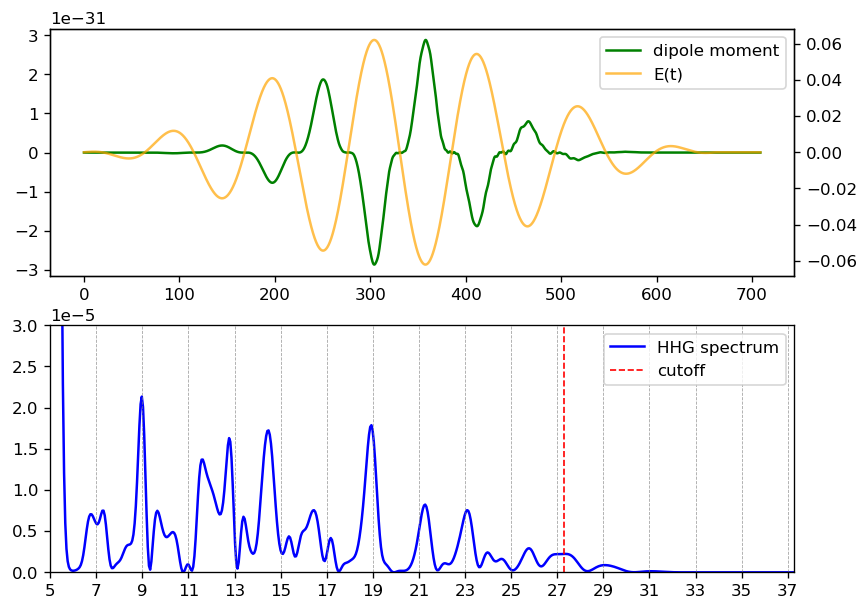

In [133]:
fig, (axt, axw) = plt.subplots(2,1, figsize=(8,6))
axl = axt.twinx()
p1, = axt.plot(t_au, d_lew, 'green', label='dipole moment')
p2, = axl.plot(t_au, E_au, 'orange', alpha=0.7, label='E(t)')
axl.legend(handles=[p1, p2])

p3, = axw.plot(ho, hhg_lew, 'blue', label='HHG spectrum')
# p3, = axw.semilogy(ho, hhg_lew, 'blue', label='HHG spectrum')
axw.set_xticks([1+2*i for i in range(50)])
axw.set_xlim(5, cutoff_ho+10)
# axw.set_xlim(0, 100)
axw.set_ylim(0, np.amax(hhg_lew)*3e-5)
for i in range(50):
    axw.axvline(1+2*i, linewidth=0.5, linestyle='--', color='gray', alpha=0.7)
p4 = axw.axvline(cutoff_ho, linewidth=1.0, linestyle='--', color='red', label='cutoff')
axw.legend(loc='upper right', handles=[p3, p4])

# TDDFT calculation on $\mathrm{N}_2$ molecule

In [5]:
os.chdir(notebook_path)

Now that we saw the TDDFT calculation ofr an atomistic case, let's try a bit different, using an N2 molecule. We follow similar steps as before.

The input file for the ground state calculation is given in directory under the name test_octopus. 

OR

You can create this directory here:

In [6]:
tmpdir_N2=os.path.abspath(os.path.join(notebook_path, 'test_octopus'))
# Make new directory
if not os.path.isdir(tmpdir_N2):
    os.makedirs(tmpdir_N2)
    print('Created calculation directory: '+ tmpdir_N2)
else:
    print('Using existing directory ' + tmpdir_N2)

Using existing directory /home/nagyg/Projects/ElissNotebook/Codes/ASE_Octopus_Demo/test_octopus


In [7]:
os.chdir(tmpdir_N2)

## Ground-state calculation for $\mathrm{N}_2$

We use the following geometrical coordinates for the molecule, and write it to an XYZ file using ASE: N2.xyz
```
2

N      -0.66044100      -0.00736549       0.00000000
N       0.29863339       0.51058848       0.00000000

0
```

In [178]:
from ase import Atoms, io
n2_mol = Atoms(('N','N'), ((-0.66044100, -0.00736549, 0.00000000), (0.29863339, 0.51058848, 0.00000000)))
xyz_path = os.path.join(tmpdir_N2, 'N2.xyz')
io.write(xyz_path, n2_mol, format='xyz')
# with open(Oct_dir+'\\N2.xyz','w') as N2_geo:
    # N2_geo.write('2 \n \n N -0.66044100 -0.00736549 0.00000000 \n N 0.29863339 0.51058848 0.00000000')

Let's verify what did we get.

In [179]:
os.system('cat ' + xyz_path)

2

N      -0.660441000000000     -0.007365490000000      0.000000000000000
N       0.298633390000000      0.510588480000000      0.000000000000000


0

Time to run the ground state step. Octopus code executes the command with input file name as 'inp'. Hence, for ground state calculations we copy the file 'N2.gs.inp' to 'inp'.

The input file:

```
CalculationMode = gs
Dimensions = 3
fromScratch = yes

**#Shape of the simulation box**
BoxShape = sphere

**#In the original reference, the spacing is 0.25 a.u.**
Spacing = 0.35

**#In the original reference, the box is 300 a.u. long. p**
Radius = 200.0

**#We use Kohn Sham method**
TheoryLevel = kohn_sham

**#Coordinates for N2 molecule**
XYZCoordinates = "N2.xyz"

**#Maximum number of iterations for SCF calculations**
MaximumIter = 300

**#Boundaries of the simulation box absorbing defined with mask function.**
AbsorbingBoundaries = mask

**#Specifies the boundary width**
AbWidth = 50
```


In [188]:
inp_file = '''
CalculationMode = gs 
Dimensions = 3 
fromScratch = yes 
BoxShape = sphere 
Spacing = 0.35 
Radius = 200.0 
#We use Kohn Sham method 
TheoryLevel = kohn_sham 
#Coordinates for N2 molecule 
XYZCoordinates = "N2.xyz" 
#Maximum number of iterations for SCF calculations 
MaximumIter = 300 
#Boundaries of the simulation box absorbing defined with mask function. 
AbsorbingBoundaries = mask 
#Specifies the boundary width 
AbWidth = 50 
'''
gs_fpath = os.path.join(tmpdir_N2, 'N2.gs.inp')
try:
    shutil.copyfile(gs_fpath, os.path.join(tmpdir_N2, 'inp'))
except:
    with open(gs_fpath,'w+') as f:
        print(inp_file, file=f)
    shutil.copyfile(gs_fpath, os.path.join(tmpdir_N2, 'inp'))

Again, if in any doubt about the input file parameters, you can use `oct-help` to look it up:

In [189]:
parameter_to_lookup = "XYZCoordinates"
os.system(f"oct-help -p " + parameter_to_lookup)

Variable: XYZCoordinates
Type:     string
Section:  System::Coordinates
Description:
    If  PDBCoordinates is not present, the program reads the atomic coordinates
    from  the XYZ file specified by the variable XYZCoordinates -- in case this
    variable  is  present. The XYZ format is very simple: The first line of the
    file  has an integer indicating the number of atoms. The second can contain
    comments that are simply ignored by
    Octopus.  Then  there  follows  one  line per atom, containing the chemical
    species and the Cartesian coordinates of the atom.
    
    Units  and/or  UnitsInput, which means Octopus might expect xyz files to be
    in  atomic  units. If you want the XYZ file to be read in Angstrom, as most
    codes do, you can set the variable UnitsXYZFiles to
    angstrom.


0

Time to run the ground-state calculation:

In [ ]:
run_gs_calc = True
if run_gs_calc:
    os.system("octopus | tee gs.log")

The output file for the ground state calculations is given in test_octopus directory as `gs.log`. This calculation takes about 32 mins when run in serial, so the outputs are already included. You don't have to run this now, but, of coure, feel free to try it outside the class.

The ouptup of the calculation will give several SCF iterations and end with:

#State  Eigenvalue (H) Occupation    Error

      1       -1.045563    2.000000   (2.6E-05)
      
      2       -0.505260    2.000000   (2.0E-05)
      
      3       -0.470952    2.000000   (3.8E-05)
      
      4       -0.406124    2.000000   (2.7E-06)
      
      5       -0.359920    2.000000   (3.1E-05)


The ionization potential of 0.36 Hartree (9.80eV) is a poor match for experimental value of [15.6eV](https://webbook.nist.gov/cgi/cbook.cgi?ID=C7727379&Mask=20). However, quantitative results is beyond the scope of this tutorial. The ionization potential value can be improved by using different method for calculation (see [M.R. Mack et al. 2013](https://doi.org/10.1016/j.cplett.2012.11.045)).

## Time-dependent calculation for $\mathrm{N}_2$

Now we run the time dependent (td) calculations:

The input file of the td calculations is given as 'N2.td.inp' which is present in the test directory. If not one can create using:
```
#This test calculates a three-dimensional model for nitrogen molecule, considering
CalculationMode = td
Debug = trace
Dimensions = 3
fromScratch = yes
PseudopotentialSet = pseudodojo_pbe
FilterPotentials = filter_none
XYZCoordinates = "N2.xyz"
BoxShape = sphere
Radius = 50*angstrom
Spacing = 0.3*angstrom

TheoryLevel = kohn_sham
#Frequency corresponding to 800nm.
omega = 0.05655
period = 0.6*femtosecond #*pi/omega

#In the original reference, there are 96 cycles instead of 8.
stime = 30*period

#The time-step is shorter in the original reference. But the propagation
#algorithm is also probably different.
dt = period/100
TDPropagationTime = stime
TDPropagator = exp_mid
TDExponentialMethod = lanczos
TDExpOrder = 20
TDTimeStep = dt
%TDExternalFields
electric_field   | 1 | 0 | 0 | omega | "envelope_function"
%
electric_amplitude = (sqrt(4*10^14)/sqrt(3.509470*10^16))
%TDFunctions
"envelope_function" | tdf_from_expr | "electric_amplitude*(sin(pi/stime*t))^2"
%
#AbsorbingBoundaries = cap
AbsorbingBoundaries = mask
AbWidth = 50
%TDOutput 
 laser
 multipoles 
 dipole_acceleration
%
```

In [183]:
td_inp = '''
CalculationMode = td 
Debug = trace 
Dimensions = 3 
fromScratch = yes 
PseudopotentialSet = pseudodojo_pbe 
FilterPotentials = filter_none 
XYZCoordinates = "N2.xyz" 
BoxShape = sphere 
Radius = 50*angstrom 
Spacing = 0.3*angstrom 
TheoryLevel = kohn_sham 

#Frequency corresponding to 800nm. 
omega = 0.05655 
period = 0.6*femtosecond 
#In the original reference, there are 96 cycles instead of 8. 
stime = 30*period 

dt = period/100 
TDPropagationTime = stime 
TDPropagator = exp_mid 
TDExponentialMethod = lanczos 
TDExpOrder = 20 
TDTimeStep = dt 
%TDExternalFields 
electric_field   | 1 | 0 | 0 | omega | "envelope_function" 
% 
electric_amplitude = (sqrt(4*10^14)/sqrt(3.509470*10^16)) 
%TDFunctions 
"envelope_function" | tdf_from_expr | "electric_amplitude*(sin(pi/stime*t))^2" 
% 
AbsorbingBoundaries = mask 
AbWidth = 50 
%TDOutput 
 laser 
 multipoles 
 dipole_acceleration 
%
'''
td_fpath = os.path.join(tmpdir_N2, 'N2.td.inp')
try:
    shutil.copyfile(td_fpath, os.path.join(tmpdir_N2, 'inp'))
except:
    with open(td_fpath,'w+') as f:
        print(inp_file, file=f)
    shutil.copyfile(td_fpath, os.path.join(tmpdir_N2, 'inp'))

To execute octopus td calculations you can execute in terminal:

> octopus | tee td.log 

This takes a long time though, so during the lesson, we will use the result of an already executed calculation. Feel free to run this calculation outside the lesson.

In [184]:
RUN_TD = False
if RUN_TD:
    os.system('octopus | tee td.log')

This time, we use Octopus's built-in tool do calculate the HHG spectrum:
```onic-spectrum -m 1


In [ ]:
CALC_HARM = False
if CALC_HARM:
    os.system('oct-harmonic-spectrum -m 1')

This command will generate hs-mult.x file. 

The hs-mult.x file contains:
#w                  H(w) 

#H             (b/hbar/H^2 

   0.000000E+00   0.335852E-03
   
   0.514091E-02   0.402734E-03
   
   0.102818E-01   0.863577E-03
   
   0.154227E-01   0.328424E-04
   
$\dots \dots$ 

On plotting the hs-mult.x file we get the harmonic generation dipole power spectrum.

/home/nagyg/Projects/ElissNotebook/Codes/ASE_Octopus_Demo/test_octopus/hs-mult.x


Text(0, 0.5, 'Harmonic intensity (arb. units)')

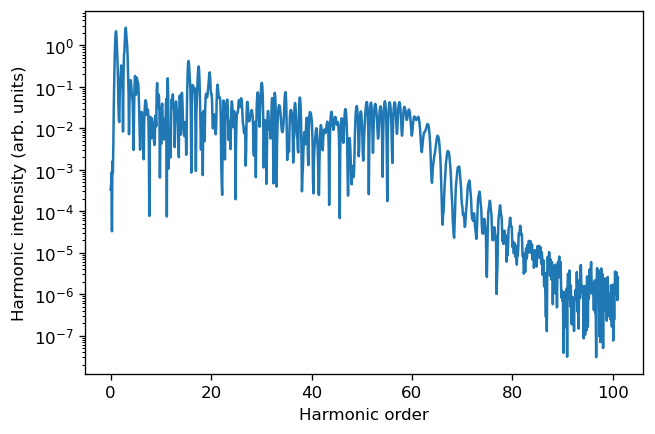

In [8]:
hs_file = os.path.join(tmpdir_N2, 'hs-mult.x')
print(hs_file)
df = pd.read_csv(hs_file,header=None,skiprows=2, delim_whitespace=True)
plt.semilogy(df[0]/0.056,df[1],label='N2')
plt.xlabel('Harmonic order')
plt.ylabel('Harmonic intensity (arb. units)')